#**Computer Vision Assignment 3**

    Amr Ayman Ibrahim Momtaz                   18011178
    Asmaa Ramadan Khamis                       18015029
    Mariam Ahmed Mohamed Ghazi                 18015032




## **Part 1: Block Matching**

In [ ]:
# Importing libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from tqdm import tqdm

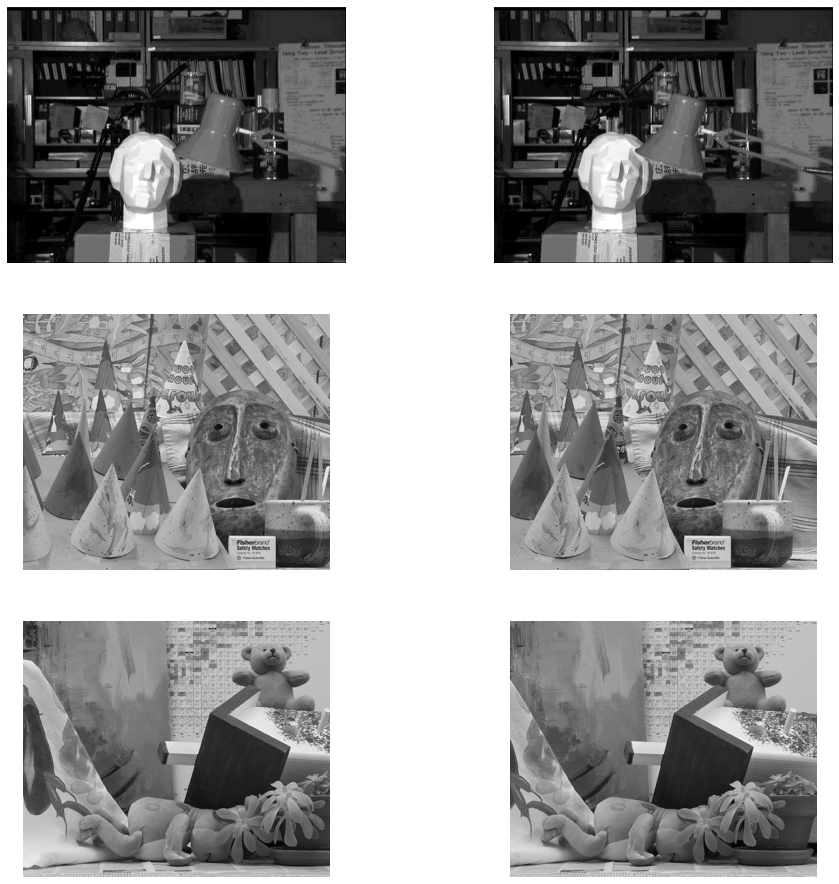

In [ ]:
# Reading images
l1 = cv2.imread('l1.png', 0)
r1 = cv2.imread('r1.png', 0)
l2 = cv2.imread('l2.png', 0)
r2 = cv2.imread('r2.png', 0)
l3 = cv2.imread('l3.png', 0)
r3 = cv2.imread('r3.png', 0)

plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.imshow(l1, cmap="gray")
plt.axis(False)
plt.subplot(3, 2, 2)
plt.imshow(r1, cmap="gray")
plt.axis(False)
plt.subplot(3, 2, 3)
plt.imshow(l2, cmap="gray")
plt.axis(False)
plt.subplot(3, 2, 4)
plt.imshow(r2, cmap="gray")
plt.axis(False)
plt.subplot(3, 2, 5)
plt.imshow(l3, cmap="gray")
plt.axis(False)
plt.subplot(3, 2, 6)
plt.imshow(r3, cmap="gray")
plt.axis(False)
plt.show()

In [ ]:
''' 
Calculates and display the disparity map given the window size
and a boolean determines whether to use SAD or SSD.
'''
def display_disparity(window, sad, img_left, img_right):
  displacement = int(img_left[1].shape/((window+1)*2))
  rows, cols = img_right.shape
  disparity_img = np.zeros(img_right.shape)
  for row in range(rows):

    min_row = max(0, row - int((window+1)/2))
    max_row = min(rows-1, row + int((window+1)/2))

    for column in range(cols):
      min_col = max(0, column - int((window+1)/2))
      max_col = min(cols-1, column + int((window+1)/2))
      minimum_displacement = max(-displacement, -min_col)
      maximum_displacement = min(displacement, cols - max_col - 1)
      template = img_left[min_row:max_row, min_col:max_col].astype(int) # Template
      num_blocks = maximum_displacement - minimum_displacement
      accumulator = np.zeros([num_blocks])
      for i in range(minimum_displacement, maximum_displacement):
        block = img_right[min_row:max_row, (min_col+i):(max_col+i)].astype(int) # Block
        block_index = i - minimum_displacement
        if sad: # Calculates the sum of absolute differences
          accumulator[block_index] = np.sum(np.abs(np.subtract(template, block)))
        else: # Calculates the sum of sqaured diffrences
          accumulator[block_index] = np.sum(np.power(np.subtract(template, block),2))
      match_index = np.argmin(accumulator)
      disparity = abs(match_index + minimum_displacement) # Disparity
      disparity_img[row, column] = disparity
  # Displaying the output
  if sad:
    plt.title(f'Disparity using SAD and window size {window}')
  else:
    plt.title(f'Disparity using SSD and window size {window}')
  plt.imshow(disparity_img, cmap="gray")
  plt.axis(False)
  plt.show()

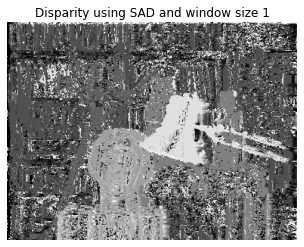

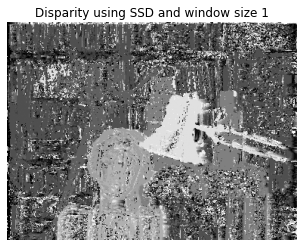

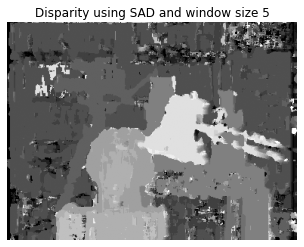

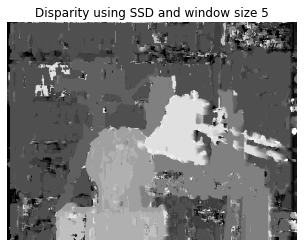

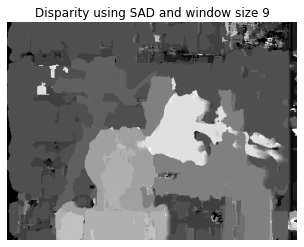

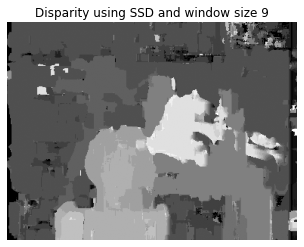

In [ ]:
windows = [1, 5, 9]
# First image
for window in windows: # Looping over different window sizes
  display_disparity(window, True, l1, r1) # Using SAD
  display_disparity(window, False,  l1, r1) # Using SSD

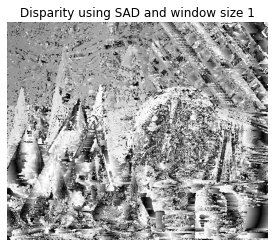

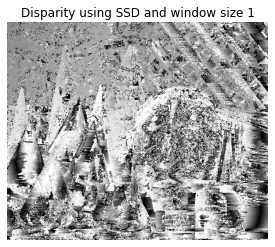

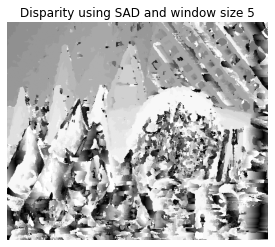

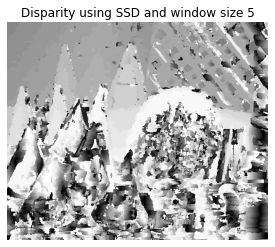

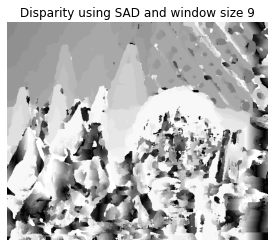

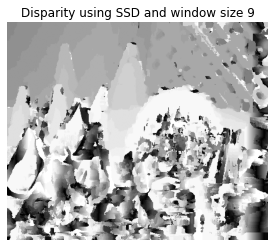

In [ ]:
# Second Image
for window in windows: # Looping over different window sizes
  display_disparity(window, True, l2, r2) # Using SAD
  display_disparity(window, False, l2, r2) # Using SSD

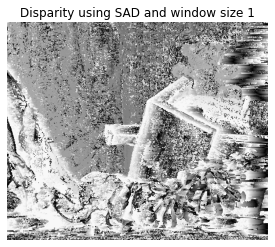

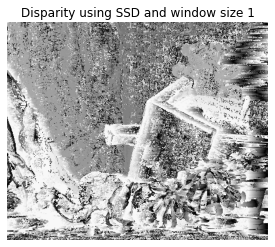

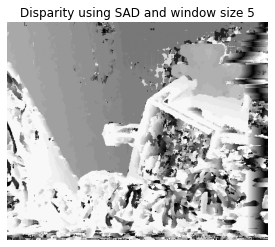

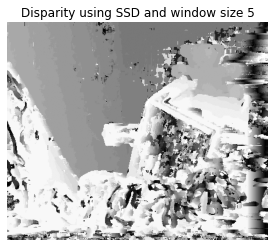

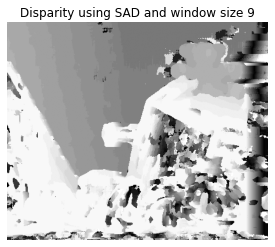

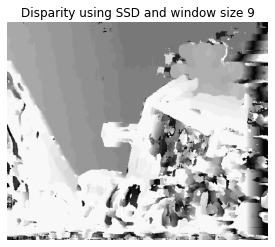

In [ ]:
# Third Image
for window in windows: # Looping over different window sizes
  display_disparity(window, True, l3, r3) # Using SAD
  display_disparity(window, False, l3, r3) # Using SSD

## **Part 2: Dynammic Progamming**

In [ ]:
def SSD(pixelL,pixelR,sigma=2):
  ssd = (pixelL-pixelR)**2/(sigma**2)
  return ssd
     

In [ ]:
def dynamic_matching_forward(rowL, rowR):
  
  N = rowL.shape[0]
  M = rowR.shape[0]
  cost_matrix = np.ones((N,M))
  match_matrix = np.zeros((N,M))

  occlusion_cost = 1

  cost_matrix[0][0] = SSD(rowL[0], rowR[0])

  for i in range(1, N):
    cost_matrix[i][0] = i*occlusion_cost
  for j in range(1, M):
    cost_matrix[0][j] = j*occlusion_cost

  
  for i in range(1, N):
      for j in range(1, M):
        min1 = cost_matrix[i - 1][j -1] + SSD(rowL[i], rowR[j])
        min2 = cost_matrix[i - 1][j] + occlusion_cost
        min3 = cost_matrix[i][j - 1] + occlusion_cost

        cost_matrix[i][j] = cmin = min(min1, min2, min3)

        if(cmin == min1):
          match_matrix[i][j] = 1
        elif(cmin == min2):
          match_matrix[i][j] = 2
        elif(cmin == min3):
          match_matrix[i][j] = 3

  return (match_matrix, cost_matrix)

In [ ]:

def dynamic_matching_backtrack(match_matrix):
  rowL = rowR = match_matrix.shape[0]-1
  disp_vec = np.zeros((match_matrix.shape[0],1))
  disp_acc = 0

  x=[]
  y=[]

  opt_path = np.zeros((match_matrix.shape[0]**2))
  opt_pos = 0
  while(rowL!=0 and rowR!=0):
    z = match_matrix[rowL][rowR]

    x.append(rowL)
    y.append(rowR)

    if(z==1):
      rowL -= 1 
      rowR -= 1
      disp_vec[rowL] = abs(rowR-rowL)
    elif(z==2):
      rowL -= 1 
      disp_acc += 1
      disp_vec[rowL] = 0
    elif(z==3):
      rowR -= 1
      disp_acc -= 1
    
  return (disp_vec, x,y)
     

In [ ]:
def result_disparity(img, disp):
  cv2_imshow(img)
  factor = 255/max(np.unique(disp))
  cv2_imshow(disp*factor)
  return 

In [ ]:
def dynamic_disparity(imgL, imgR):
  imgL_bw = np.asarray(imgL, dtype = np.float32)
  imgR_bw = np.asarray(imgR, dtype = np.float32)
  
  disp_map = np.zeros(imgR_bw.shape)

  x_matrix=[]
  y_matrix=[]


  for row in tqdm(range(imgL_bw.shape[0])):
    row_match_matrix, row_cost_matrix = dynamic_matching_forward(imgL_bw[row], imgR_bw[row])

    disp_row, x,y = dynamic_matching_backtrack(row_match_matrix)

    x_matrix.append(x)
    y_matrix.append(y)


    disp_map[row] = disp_row.reshape(imgL_bw.shape[1])
  result_disparity(imgL_bw, disp_map)  

  return disp_map,x_matrix,y_matrix

100%|██████████| 289/289 [04:49<00:00,  1.00s/it]


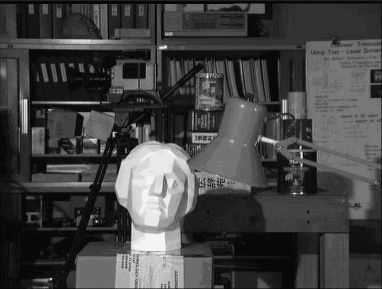

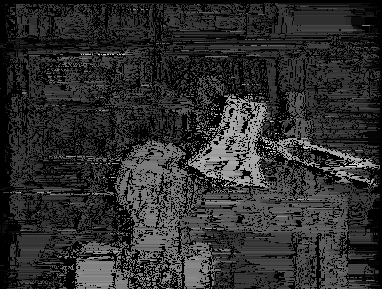

In [ ]:
disp,x_matrix,y_matrix = dynamic_disparity(l1, r1)

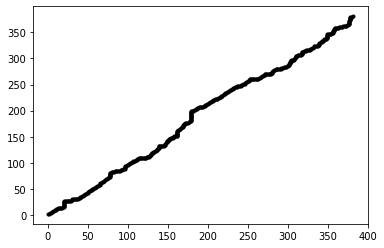

In [ ]:
plt.plot(x_matrix[50], y_matrix[50], "k.", lw=0)

100%|██████████| 375/375 [08:36<00:00,  1.38s/it]


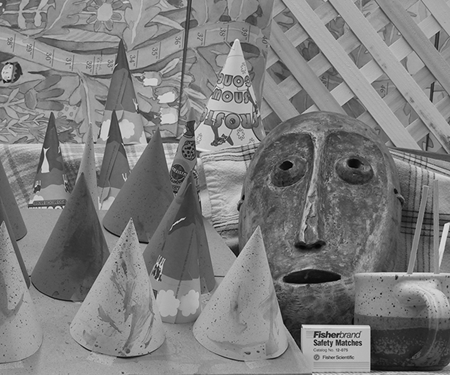

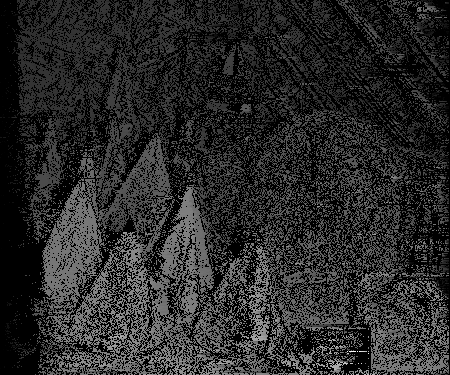

In [ ]:
disp,x_matrix,y_matrix = dynamic_disparity(l2, r2)

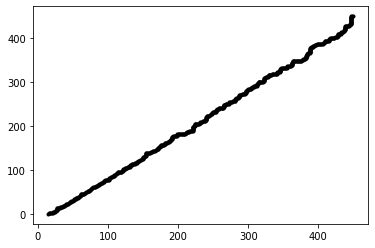

In [ ]:
plt.plot(x_matrix[50], y_matrix[50], "k.", lw=0)

100%|██████████| 375/375 [08:41<00:00,  1.39s/it]


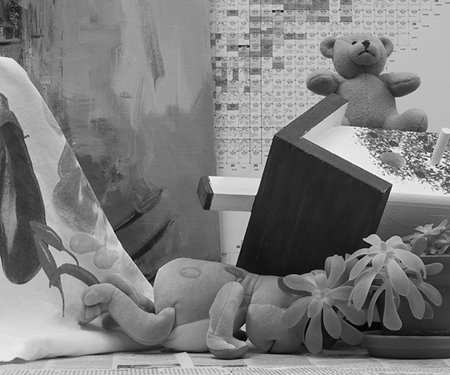

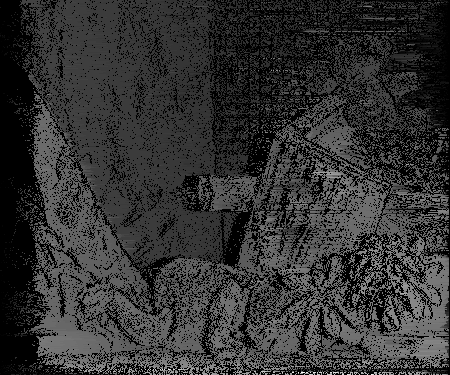

In [ ]:
disp,x_matrix,y_matrix = dynamic_disparity(l3, r3)

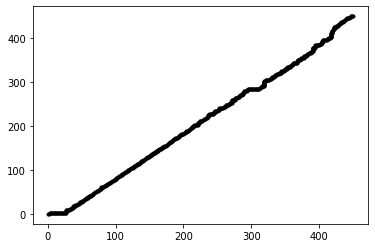

In [ ]:
plt.plot(x_matrix[50], y_matrix[50], "k.", lw=0)